Steps for project 
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
>The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

5. Detect lane lines
6. Determine the lane curvature

# Step 0) Setup everything, declare helper functions, etc

In [276]:
import cv2
import glob
import pickle
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from moviepy.editor import VideoFileClip
import numpy as np
import os
%matplotlib inline

print('Done importing everything.  System ready to rip!')

Done importing everything.  System ready to rip!


In [258]:
# Helper functions and Constants

# Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread().
# Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
# Therefore, define grayscale constant names so we don't have to keep coming back here
MPIMG_GRAY_SCALE = cv2.COLOR_RGB2GRAY
CV2_GRAY_SCALE = cv2.COLOR_BGR2GRAY  
MPIMG_HSV = cv2.COLOR_RGB2HSV
CV2_HSV = cv2.COLOR_BGR2HSV

def show(image, title='Not Supplied'):
    plt.title(title)
    plt.imshow(image)
    plt.show()

    
def show2(image, image2, left_title='', right_title=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title(left_title, fontsize=30)
    ax2.imshow(image2)
    ax2.set_title(right_title, fontsize=30)
    plt.show()
    return f, ax1, ax2

def fitx(left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx
print('Loaded all helper functions and constants!')

Loaded all helper functions and constants!


* * *
* * *
# Step 1. Camera Callibration

In [ ]:
# Gathering up data for calibrating the camera in later steps
calibration_images = glob.glob('./camera_cal/calibration*.jpg')
print('Found {} images.'.format(len(images)))

calibration_imgs = []
obj_pnts = [] # 3-D points in real world space
img_pnts = [] # 2-d points in image plane

nx = 9
ny = 6

objp = np.zeros((ny*nx, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

sum_found = 0
for file_name in calibration_images:
    img = mpimg.imread(file_name)
    calibration_imgs.append(img)
    gray = cv2.cvtColor(img, MPIMG_GRAY_SCALE)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #if ret == False: # 2 of the images observed to have worked with 8,6
      # unfortunately, change nx,ny doesn't play nicely with objp
    title = 'Did not find corners for {}'
    if ret == True:
        sum_found += 1
        img_pnts.append(corners)
        obj_pnts.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        title = 'FOUND corners for {}'

    show(img, title.format(file_name))
   
print('Actually found {} of the {} images.'.format(sum_found, len(calibration_images)))

* * *
* * *
## Step 2) Test out the calibration computed in last step by undistorting

Also provide undistort image function to be used by pipeline

In [ ]:
def undistort(img, return_calibration_data=False):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pnts, img_pnts, img_size, None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted #,ret,mtx,dist  if return_calibration_data
    
for img in calibration_imgs:
    undistorted = undistort(img)
    show2(img, undistorted, 'Distorted', 'Undistorted')

# Thanks to https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# for how to plot two images side-by-side

* * *
* * *
# Step 3) Color/gradient threshold

## Step3A) Create gradient-based thresholding functions

In [100]:
## All three methods below apply the same steps, so do that all here
def prepare_thresholding(img, sobel_kernel, grayscale=MPIMG_GRAY_SCALE):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, grayscale)
    
    # 2) Take the derivative in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobelx, sobely

# To accomidate need for magnitude to be strictly greater than, 
#  the absolute and mag thresholds will use -1 as thresh_min default.
#  rational: even if forget this later, one pixel different won't be as bad as one degress off for directional
def apply_threshold(calced_soble, thresh_min, thresh_max):
    # 5) Create a mask of 1's where the calculated sobel (be it magnitute, directional or whatnot)
    #      is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(calced_soble)
    sxbinary[(calced_soble > thresh_min) & (calced_soble <= thresh_max)] = 1
    return sxbinary


def abs_sobel_thresh(sobel_x_or_y, thresh_min=-1, thresh_max=255):
    ### Calculate directional gradient ###
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_x_or_y)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    ### Apply threshold ###
    grad_binary = apply_threshold(scaled_sobel, thresh_min, thresh_max)

    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(sobelx, sobely, thresh_min=-1, thresh_max=255):
    ### Calculate gradient magnitude ###
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(np.square(sobelx) + np.square(sobely))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8)

    ### Apply threshold ###
    mag_binary = apply_threshold(gradmag, thresh_min, thresh_max)

    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(sobelx, sobely, thresh_min=-1, thresh_max=np.pi/2):
    ### Calculate gradient direction ###
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
 
    ### Apply threshold ###
    dir_binary = apply_threshold(grad_dir, thresh_min, thresh_max)

    # 6) Return this mask as your binary_output image
    return dir_binary

# Apply each of the thresholding functions
# This is where we can make the key changes to our thresholding
def apply_combined_threshold(image, sobel_kernel=13):
    sobelx, sobely = prepare_thresholding(image, sobel_kernel)
    gradx = abs_sobel_thresh(sobelx, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(sobely, thresh_min=25, thresh_max=90)
    mag_binary = mag_thresh(sobelx, sobely, thresh_min=25, thresh_max=130)
    dir_binary = dir_threshold(sobelx, sobely, thresh_min=0.8, thresh_max=1.1)

    combined = np.zeros_like(dir_binary) 
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

print('Loaded all threshold-related functions')

Loaded all threshold-related functions


## Step3B) Create color-based thesholding functions

In [242]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, S_thresh=(90, 255), V_thresh=(90, 255), color_scale=MPIMG_HSV):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, color_scale) 
    H = hls[:,:,0]
    #L = hls[:,:,1]
    S = hls[:,:,1] # 2 for HLS
    V = hls[:,:,2]
    
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[( ((S >= S_thresh[0]) & (S <= S_thresh[1])) & ((V >= V_thresh[0]) & (V <= V_thresh[1])) )] = 1
    
    # 3) Return a binary image of threshold result
    return binary


print('Loaded all color-related functions')

Loaded all color-related functions


## Step3C) Combine A and B and try it all out

In [232]:
def thresholding_pipeline(img):
    s_binary = hls_select(img)
    sxbinary = apply_combined_threshold(img)
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # TODO: replace with what?? Hmm.. Perhaps make it a single channel rather than 'stacking' them?
    #color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    selection = selection = np.zeros_like(s_binary)
    selection[(s_binary == 1) | (sxbinary == 1)] = 1
    return selection

print('Loaded _THE_ pipeline!')

Loaded _THE_ pipeline!


In [ ]:
# Let's try them out on the test image supplied from lectures
#test_img = mpimg.imread('examples/signs_vehicles_xygrad.png')
#thresholded_img = apply_combined_threshold(test_img)
#show2(test_img, thresholded_img, 'Original', 'Thresholded')

# Nevermind above, let's try them on ALL the images available to test!
test_images = glob.glob('./test_images/*.jpg')
print('Found {} images to test.'.format(len(test_images)))

for img_file_name in test_images:
    img = mpimg.imread(img_file_name)
    undistorted_img = undistort(img)
    thresholded_img = thresholding_pipeline(undistorted_img)
    show2(undistorted_img, thresholded_img, 'Original (undist) {}'.format(img_file_name.split('/')[-1]), 'Thresholded')


* * *
* * *
# Step 4) Perspective Transform

Changes in latitude, changes in attitude?
Transformers, robots in disguise?


In [ ]:
# Is very much like what we did with chess-board, but instead of finding chessboard corners, manually specify

# In my first lane-finding project, I used a percentage concept to define boundaries, will do similar here
#   to maybe be agnostic toward image size

    
### Not sure if it's important to have corners in right order, so I used this to help think through points

# example src
#[[[  436.50708008   114.33555603]]
# [[ 1103.99841309   224.66326904]]
# [[ 1075.51147461   658.02740479]]
# [[  465.32727051   768.5894165 ]]]

# example dst
#[[  100.   100.]
# [ 1180.   100.]
# [ 1180.   860.]
# [  100.   860.]]
 
# result src
#[[  153.6000061    698.40002441]
# [  473.6000061    309.6000061 ]
# [  896.           309.6000061 ]
# [ 1216.           698.40002441]]
#result dst

#[[   50.   670.]
# [   50.    50.]
# [ 1230.    50.]
# [ 1230.   670.]]

def transform(img, debug=False):
    xsize = img.shape[1]
    ysize = img.shape[0]
    cutoff_bottom = ysize * .03 # try to cut off a little of the car's hood
    left_bottom  = [xsize * 0.16, ysize - cutoff_bottom]
    right_bottom = [xsize * 0.9, ysize - cutoff_bottom]

    #trapezoid_offset = xsize *.3 # Random guess how much to narrow top of region box
    cutoff_top = ysize * .35 # Take a bit more than half maybe?
    left_top  = [left_bottom[0]  + 300, ysize - cutoff_top]
    right_top = [right_bottom[0] - 320, ysize - cutoff_top]

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([left_bottom, left_top, right_top, right_bottom])
    if debug:
        print(src)    
        color=[0, 255, 0]
        thickness=4
        cv2.line(img, (left_bottom[0].__int__(), left_bottom[1].__int__()),
                      (left_top[0].__int__(), left_top[1].__int__()), color, thickness)
        cv2.line(img, (right_top[0].__int__(), right_top[1].__int__()), 
                      (right_bottom[0].__int__(), right_bottom[1].__int__()), color, thickness)

    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst_lb = [offset, ysize - offset]  # left bottom   
    dst_lt = [offset, offset]           # left top 
    dst_rt = [xsize - offset, offset]  # right top
    dst_rb = [xsize - offset, ysize - offset] # right bottom
    dst = np.float32([dst_lb, dst_lt,
                        dst_rt, dst_rb]) 

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (xsize, ysize))
    if debug:
        print(dst)    
        color=[0, 0, 255]
        thickness=10
        cv2.line(warped, (dst_lb[0].__int__(), dst_lb[1].__int__()), 
                         (dst_lt[0].__int__(), dst_lt[1].__int__()), color, thickness)
        cv2.line(warped, (dst_rt[0].__int__(), dst_rt[1].__int__()),
                         (dst_rb[0].__int__(), dst_rb[1].__int__()), color, thickness)

    # Return the resulting image, but not the matrix until we use it?
    return warped, M

print('Loaded up transformative functions...they\'ll change your mind!')

## TODO: for now, keep these two in same place, copy to next cell when done
test_images = glob.glob('./test_images/test*.jpg') # remove test if we want to compare with a few others placed there
for img_file_name in test_images:
    img = mpimg.imread(img_file_name)
    undistorted_img = undistort(img)

    thresholded_img = thresholding_pipeline(undistorted_img)
    top_down_thresh, M = transform(thresholded_img)

    top_down, M = transform(undistorted_img, debug=True)
    show2(undistorted_img, top_down, 'Original (undist) {}'.format(img_file_name.split('/')[-1]), 'TransfORMED (Free as a bird)')

    show(top_down_thresh, 'Top down thresholded view')
    #break

In [ ]:
# Use same images from thresholding, to see results of transforming their perspectives


***
***
# Step 5) Detect Lane Lines

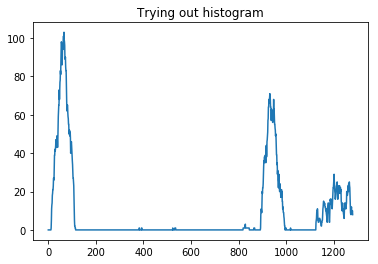

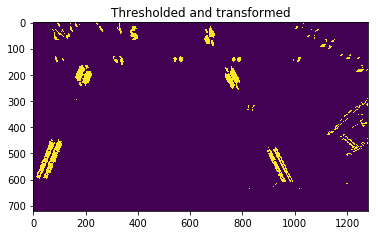

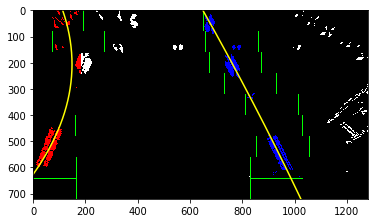

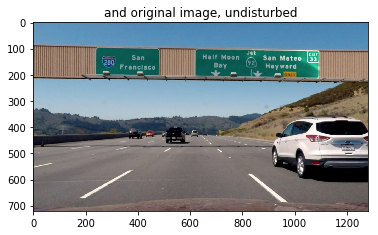

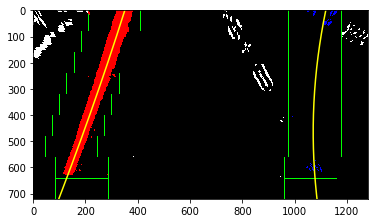

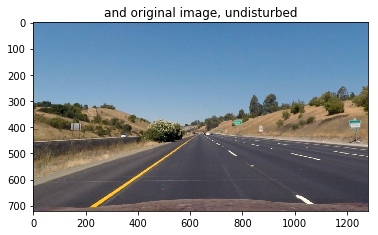

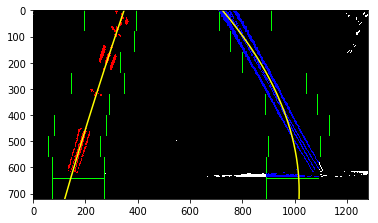

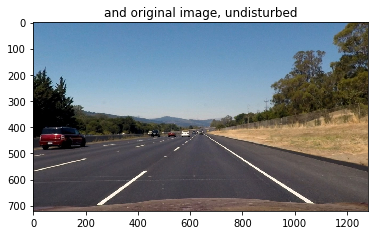

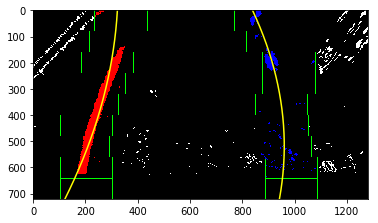

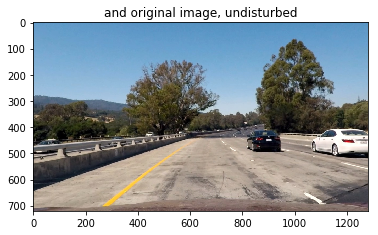

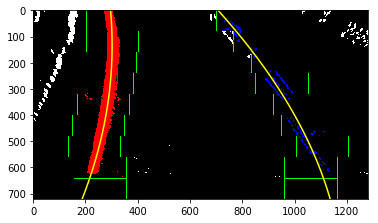

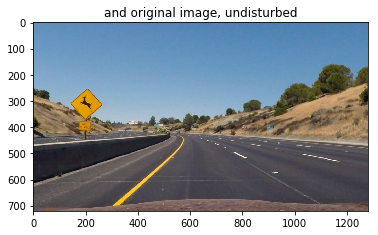

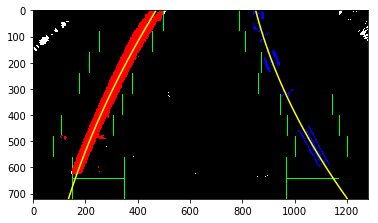

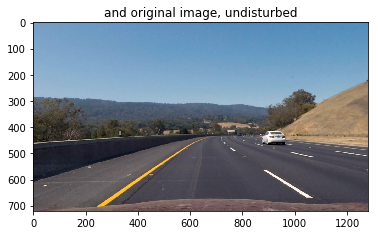

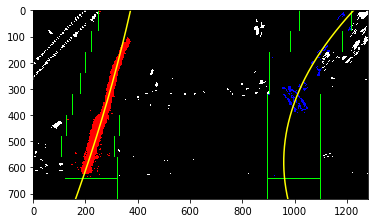

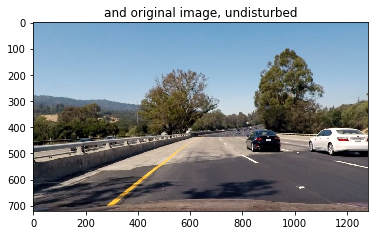

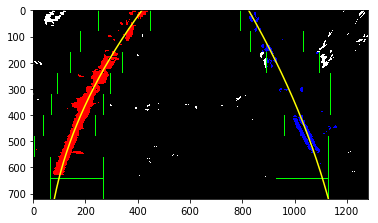

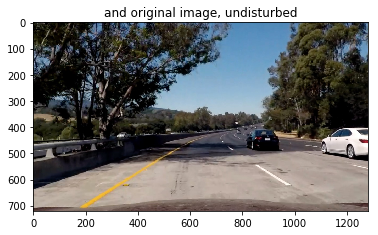

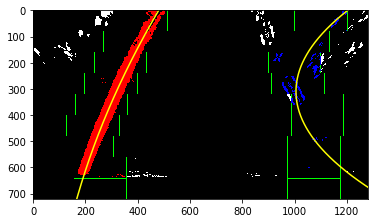

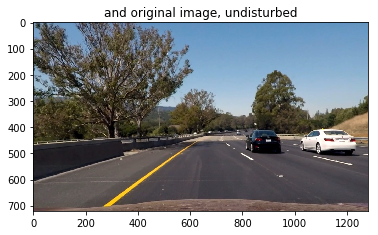

In [261]:
hist_img = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')

undist_hist_img = undistort(hist_img)
thresh_hist_img = thresholding_pipeline(undist_hist_img)
top_down_thresh_hist, M = transform(thresh_hist_img)

histogram = np.sum(top_down_thresh_hist[top_down_thresh_hist.shape[0]//2:,:], axis=0)
plt.title('Trying out histogram')
plt.plot(histogram)
plt.show()
show(top_down_thresh_hist, 'Thresholded and transformed')

def hist_pipeline(binary_warped, debug=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ### Visualize

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    if debug:
        left_fitx, right_fitx = fitx(left_fit, right_fit, ploty)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return left_fit, right_fit, ploty

### Histogram approach ###
for img_file_name in test_images:
    img = mpimg.imread(img_file_name)
    undistorted_img = undistort(img)
    thresholded_img = thresholding_pipeline(undistorted_img)
    top_down_thresh, M = transform(thresholded_img)

    left_fit, right_fit, ploty = hist_pipeline(top_down_thresh, debug=True)
    show(undistorted_img, "and original image, undisturbed")


In [ ]:
### Convolutional approach ##

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

for img_file_name in test_images:
    # Read in a thresholded image
    img = mpimg.imread(img_file_name)
    undistorted_img = undistort(img)
    thresholded_img = thresholding_pipeline(undistorted_img)
    top_down_thresh, M = transform(thresholded_img)
    warped = top_down_thresh

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results for {}'.format(img_file_name.split('/')[-1]))
    plt.show()


# Step 6)  Determine Lane Curvature

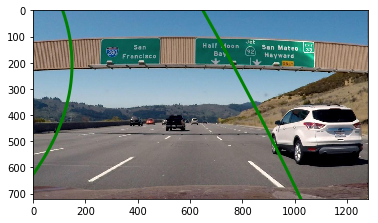

1370.16361655 10817.208632
562.290008178 m 527.782431661 m


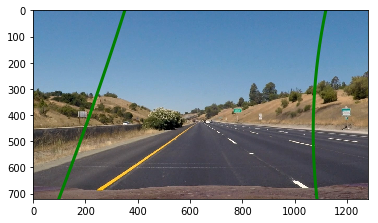

13235.7757572 2290.88808676
562.290008178 m 527.782431661 m


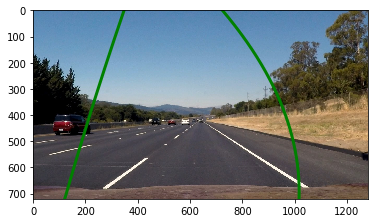

14469.7482535 821.322748618
562.290008178 m 527.782431661 m


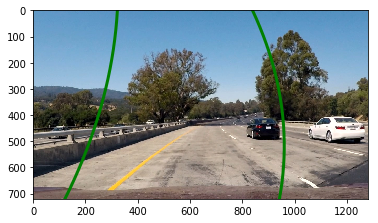

2275.11970298 1163.6921312
562.290008178 m 527.782431661 m


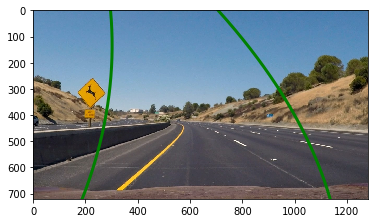

1856.8945923 1328.45235412
562.290008178 m 527.782431661 m


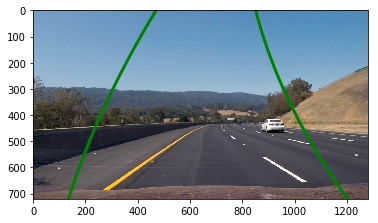

2870.01193766 2927.07096194
562.290008178 m 527.782431661 m


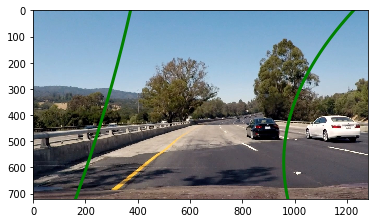

6515.2072757 676.38860368
562.290008178 m 527.782431661 m


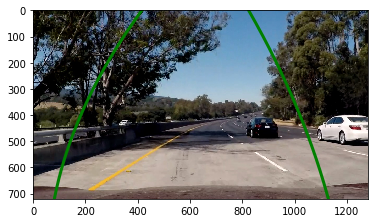

1424.86880555 2668.25644971
562.290008178 m 527.782431661 m


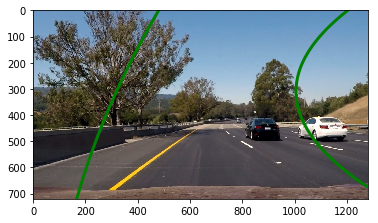

2669.23961416 1821.24301652
562.290008178 m 527.782431661 m


In [256]:
def lane_curve(left_fit, right_fit, ploty, debug=False):
    left_fitx, right_fitx = fitx(left_fit, right_fit, ploty)

    # Plot up the fake data
    mark_size = 3
    #plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    #plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    if debug:
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
        plt.show()

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    if debug:
        print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48



    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if debug:
        print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m

    return left_curverad, right_curverad

for img_file_name in test_images:
    img = mpimg.imread(img_file_name)
    undistorted_img = undistort(img)
    thresholded_img = thresholding_pipeline(undistorted_img)
    top_down_thresh, M = transform(thresholded_img)

    left_fit, right_fit, ploty = hist_pipeline(top_down_thresh
    plt.imshow(img)
    left_curvead, right_curvead = lane_curve(left_fit, right_fit, ploty, debug=True)


***
***
# Steps 7, 8, 9
## (And that's why 6 is afraid of 7)

In [ ]:
def lane_pipeline(img, debug=False):
    undistorted_img = undistort(img)
    thresholded_img = thresholding_pipeline(undistorted_img)
    top_down_thresh, M = transform(thresholded_img)
    Minv = np.linalg.inv(M)

    left_fit, right_fit, ploty = hist_pipeline(top_down_thresh)
    left_curvead, right_curvead = lane_curve(left_fit, right_fit, ploty)
    
    left_fitx, right_fitx = fitx(left_fit, right_fit, ploty)
    
    warped = top_down_thresh
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.imshow(result)

    if debug:
        plt.show()

    return result

for img_file_name in test_images:
    print(img_file_name)
    img = mpimg.imread(img_file_name)
    lane_pipeline(img, debug=True)

***
***
# Step 10 MOVIE TIME!
Get your popcorn

[MoviePy] >>>> Building video output/challenge_video.mp4
[MoviePy] Writing video output/challenge_video.mp4


100%|██████████| 485/485 [07:26<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/challenge_video.mp4 

CPU times: user 7min 49s, sys: 42.4 s, total: 8min 32s
Wall time: 7min 27s


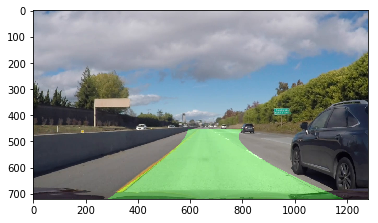

In [279]:
fileName = 'challenge_video.mp4'
  #'IMG_7462.mp4'
  #'solidWhiteRight.mp4'
  #'solidYellowLeft.mp4'

test_output = 'output/' + fileName
clip1 = VideoFileClip(fileName) # .subclip(0,5)
output_clip = clip1.fl_image(lane_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(test_output, audio=False)



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))
